<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/GAN_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: Generative adversarial networks
### LECTURE: Linear GAN with MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-4f2c8aa8e175>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the data

In [3]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

# list the categories
print(dataset.classes)

# pick three categories (leave one line uncommented)
classes2keep = [ 'Trouser','Sneaker','Pullover' ]
# classes2keep = ['Trouser', 'Sneaker', 'Sandal']

# find the corresponding data indices
images2use = torch.Tensor()

for i in range(len(classes2keep)):
    classidx = dataset.classes.index(classes2keep[i])
    images2use = torch.cat( (images2use, torch.where(dataset.targets==classidx)[0]), 0).type(torch.long)
    print(f'Added class {classes2keep[i]} (index {classidx})')

# now select just those images

# transform to dataloaders
batchsize   = 100
sampler     = torch.utils.data.sampler.SubsetRandomSampler(images2use)
data_loader = DataLoader(dataset, sampler=sampler, batch_size=batchsize, drop_last=True)

100%|██████████| 26421880/26421880 [00:00<00:00, 110614106.14it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4930299.20it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 67644223.09it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1022264.79it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Pullover (index 2)


# Create classes for the discriminator and generator

In [4]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )

dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.4777],
        [0.4576],
        [0.4988],
        [0.5124],
        [0.4751],
        [0.5005],
        [0.4288],
        [0.4665],
        [0.4745],
        [0.4723]], grad_fn=<SigmoidBackward0>)

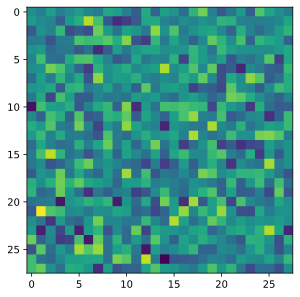

In [5]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )


gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28));

# Train the models!

In [6]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [7]:
# this cell takes ~3 mins with 50k epochs
num_epochs = int(50000/len(data_loader))

losses = np.zeros((num_epochs*len(data_loader),2))
lossi  = 0

for epochi in range(num_epochs):

    for data,_ in data_loader:

        # create minibatches of REAL and FAKE images
        data = data.view(batchsize,-1).to(device)

        # labels used for real and fake images
        real_labels = torch.ones(batchsize, 1).to(device)
        fake_labels = torch.zeros(batchsize, 1).to(device)


        ### ---------------- Train the discriminator ---------------- ###

        # forward pass and loss for REAL pictures
        pred_real   = dnet(data)                     # REAL images into discriminator
        d_loss_real = lossfun(pred_real, real_labels) # all labels are 1

        # forward pass and loss for FAKE pictures
        fake_images = gnet( torch.randn(batchsize, 64).to(device) ) # output of generator

        pred_fake   = dnet(fake_images)              # FAKE images into discriminator
        d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0

        # collect loss (using combined losses)
        d_loss = d_loss_real + d_loss_fake
        losses[lossi, 0]  = d_loss.item()

        # backprop
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()




        ### ---------------- Train the generator ---------------- ###

        # create fake images and compute loss
        fake_images = gnet( torch.randn(batchsize, 64).to(device) )
        pred_fake   = dnet(fake_images)

        # compute and collect loss and accuracy
        g_loss = lossfun(pred_fake,real_labels)
        losses[lossi, 1]  = g_loss.item()

        # backprop
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        lossi += 1


    # print out a status message
    msg = f'Finished epoch {epochi+1}/{num_epochs}'
    sys.stdout.write('\r' + msg)



Finished epoch 277/277

In [8]:
# create a 1D smoothing filter
def smooth(x,k=15):
    return np.convolve(x, np.ones(k)/k, mode='same')

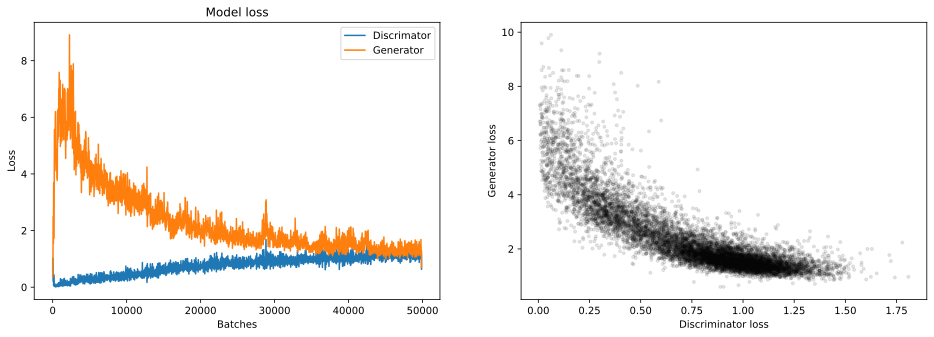

In [9]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

plt.show()

# Let's see some fake fashion!

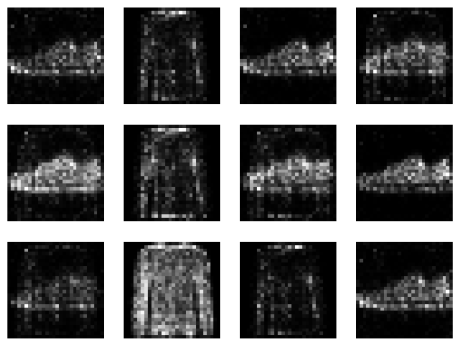

In [27]:
# generate the images from the generator network


gnet.eval()
random_data = torch.rand(12,64).to(device)
fake_data = gnet(random_data).cpu()
# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()

plt.show()